## Notes
This file contains the ResNet18 model where we added deformed convolutions to the model.

The idea is that we <b>add</b> the <b>output</b> of the <b>deformed convolution filter</b> together with a <b>regular convolution layer (conv1)</b> to learn the mapping of a wider area of the image, instead of just the convolution layer. Instead of just using a bigger convolution filter, we want to see if we can use deformable convolution to learn important features of data points outside the regular convolution layer. 

In [1]:
!pip install numpy
!pip install torch
!pip install torchvision
!pip install jupyter
!pip install matplotlib
!pip install pandas
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\Arnav\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\Arnav\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\Arnav\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\Arnav\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\Arnav\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\Arnav\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\Arnav\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import pylab
import numpy as np
import pandas as pd
import math

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torch.nn.functional as F

import torchvision
from torchvision import datasets, transforms, models, ops
from torchvision.models.resnet import ResNet, BasicBlock

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import scipy
import matplotlib.pyplot as plt
from PIL import Image
import os
import shutil
import time
from tempfile import TemporaryDirectory

In [3]:
data_dir = './'
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print(f"Downloading Training dataset:")
train_dataset = datasets.Flowers102(root=os.path.join(data_dir, "train"), split='train', transform=data_transforms['train'], download=True)
# train_dataset = datasets.Flowers102(root=os.path.join(drive_dir, "train"), split='train', transform=data_transforms['train'], download=True)

print(f"Downloading Validation dataset:")
val_dataset = datasets.Flowers102(root=os.path.join(data_dir, "train"), split='val', transform=data_transforms['val'])
# val_dataset = datasets.Flowers102(root=os.path.join(drive_dir, "train"), split='val', transform=data_transforms['val'])

print(f"Downloading Test dataset:")
test_dataset = datasets.Flowers102(root=os.path.join(data_dir, "train"), split='test', transform=data_transforms['test'])
# test_dataset = datasets.Flowers102(root=os.path.join(drive_dir, "train"), split='test', transform=data_transforms['test'])

In [4]:
batch_size = 4
datasets = {
    'train': train_dataset,
    'val': val_dataset,
    'test': test_dataset
}

# print(f"{len(train_dataset._labels)}")
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'val', 'test']}
# class_names = image_datasets['train'].classes

print(f"dataloaders: {dataloaders}")
print(f"Dataset sizes: {dataset_sizes}")


dataloaders: {'train': <torch.utils.data.dataloader.DataLoader object at 0x0000016E38670EC0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x0000016DC9501D60>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x0000016DC9501D30>}
Dataset sizes: {'train': 1020, 'val': 1020, 'test': 6149}


#### This is the training function.

In [5]:
import torch
import time
import os

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    train_loss, train_acc = [], []
    val_loss, val_acc = [], []
    
    # Save initial model parameters to restore later if needed
    best_model_params = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                # Move inputs and labels to the selected device
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            elif phase == 'val':
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)

                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_params = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_params)
    return model, train_loss, train_acc, val_loss, val_acc

## This is where we create our modified ResNet18 Convolutional Neural Network. 

We first initialise the model by inheiriting from the original ResNet architecture. We create the model in the same format as ResNet18, with the following code: 
`super(deformed_CNN, self).__init__(BasicBlock, [2, 2, 2, 2])`

We then create the deformable convolution filters for each layer of the ResNet18 architecture. We will mainly focus on the `conv1` layer of the architecture, as any more deformable layers added to the model results in a very poor accuracy. 

In [6]:
def calc_dim(layer, kernel_size, stride, padding):
    """
    This function is used to calculate the spatial dimension for each layer throughout the ResNet18 architecture. 
    """
    # print(f"Spatial Dimension: {math.floor(((layer - kernel_size + 2*(padding)) / stride) + 1)}")
    return math.floor(((layer - kernel_size + 2*(padding)) / stride) + 1)

def calc_depth(depth, name, tracking):
    """
    This function is used to calculate the depth of the filters for each layer throughout the ResNet18 architecture. 
    """
    curr_layer = name.split('.')[0]
    # print(f"{name} = {tracking}")
    if curr_layer == tracking:
        return depth, True, curr_layer
    else:
        return depth * 2, False, curr_layer

class deformed_CNN(ResNet):
    def __init__(self, batch_size, device):
        """
        We stored the offsets and weights for the deformed convolution layer here when we initialized the model.
        We used the calc_dim() function and calc_depth() function to calculate the values for the required parameters in deformed_conv2d.
        There is an issue where if the last batch of images in the dataloader is not the same size as the rest, it will crash.
        We fixed the issue by modifying the batch size of the dataloader for the last batch in the forward() function.
        """
        super(deformed_CNN, self).__init__(BasicBlock, [2, 2, 2, 2])
        self.offsets = {}
        self.weights = {}
        self.batch_size = batch_size
        # input image size before conv1 layer
        self.dim = 224
        # input image depth after conv1 layer
        self.channel = 64
        current_layer = "layer1"
        self.device = device
        
        # Here, we are creating the offset and weights for the deformed convolution layers and 
        # storing them for the forward function. 
        for name, mod in self.named_modules():
            if "conv" in name and "layer" not in name:
                # print(f"name: {name}")
                self.dim = calc_dim(
                    self.dim,
                    self.get_submodule(f"{name}").kernel_size[0],
                    self.get_submodule(f"{name}").stride[0],
                    self.get_submodule(f"{name}").padding[0]
                )
                self.offsets[name] = torch.rand(
                    self.batch_size,
                    2 * 1 * self.get_submodule(f"{name}").kernel_size[0] * self.get_submodule(f"{name}").kernel_size[0],
                    self.dim,
                    self.dim
                ).to(self.device)
                self.weights[name] = torch.rand(
                    self.channel,
#                     self.channel,
                    3,
                    self.get_submodule(f"{name}").kernel_size[0],
                    self.get_submodule(f"{name}").kernel_size[0]
                ).to(self.device)
            elif "maxpool" in name:
                # print(f"name: {name}")
                self.dim = calc_dim(
                    self.dim,
                    self.get_submodule(f"{name}").kernel_size,
                    self.get_submodule(f"{name}").stride,
                    self.get_submodule(f"{name}").padding
                )
            elif "layer" in name and "conv" in name:
                # print(f"name: {name}")
                self.dim = calc_dim(
                    self.dim,
                    self.get_submodule(f"{name}").kernel_size[0],
                    self.get_submodule(f"{name}").stride[0],
                    self.get_submodule(f"{name}").padding[0]
                )
                if ".1.conv2" in name:
                    self.offsets[name] = torch.rand(
                        self.batch_size,
                        2 * 1 * self.get_submodule(f"{name}").kernel_size[0] * self.get_submodule(f"{name}").kernel_size[0],
                        self.dim,
                        self.dim
                    ).to(self.device)
                    new_channel, truth, current_layer = calc_depth(self.channel, name, current_layer)
                    # print(f"{name}\tFeature map depth: {new_channel}")
                    if not truth:
                        self.channel = new_channel
                    self.weights[name] = torch.rand(
                        self.channel,
                        self.channel,
                        self.get_submodule(f"{name}").kernel_size[0],
                        self.get_submodule(f"{name}").kernel_size[0]
                    ).to(self.device)

    def forward(self, x):
        """
        The if condition is to check if the batch size is wrong. 
        This is mainly applied to the last batch of the data as they are not always a multiple of 4, 
        which is our defined batch size.
        
        `out1` and `out2` is where we added the output of `conv1` and the deformed_conv2d layer together into `out`
        before passing `out` into the rest of the network. 
        """
        if len(x) != self.batch_size:
            print(f"LAST LAYER: {len(x)}")
            self.offsets['conv1'] = torch.rand(
                len(x),
                2 * 1 * self.get_submodule(f"conv1").kernel_size[0] * self.get_submodule(f"conv1").kernel_size[0],
                112,
                112
            ).to(self.device)

            self.offsets['layer1.1.conv2'] = torch.rand(
                len(x),
                2 * 1 * self.get_submodule(f"conv1").kernel_size[0] * self.get_submodule(f"conv1").kernel_size[0],
                56,
                56
            ).to(self.device)

            self.offsets['layer2.1.conv2'] = torch.rand(
                len(x),
                2 * 1 * self.get_submodule(f"conv1").kernel_size[0] * self.get_submodule(f"conv1").kernel_size[0],
                28,
                28
            ).to(self.device)

            self.offsets['layer3.1.conv2'] = torch.rand(
                len(x),
                2 * 1 * self.get_submodule(f"conv1").kernel_size[0] * self.get_submodule(f"conv1").kernel_size[0],
                14,
                14
            ).to(self.device)

            self.offsets['layer4.1.conv2'] = torch.rand(
                len(x),
                2 * 1 * self.get_submodule(f"conv1").kernel_size[0] * self.get_submodule(f"conv1").kernel_size[0],
                7,
                7
            ).to(self.device)

        relu = nn.ReLU()
        
        # Here we pass `x` into both `conv1` and `deformed_conv2d` for `out1` and `out2`.
        out1 = self.conv1(x)
        out2 = ops.deform_conv2d(
            x,
            self.offsets['conv1'],
            self.weights['conv1'],
            stride=self.conv1.stride[0],
            padding=self.conv1.padding[0]
        )
        out = out1 + out2

        out = self.bn1(out)
        out = relu(out)
        out = self.maxpool(out)
        out = self.layer1(out)
        
#         out2 = ops.deform_conv2d(
#             out,
#             self.offsets['layer1.1.conv2'],
#             self.weights['layer1.1.conv2'],
#             stride=self.layer1[1].conv2.stride[0],
#             padding=self.layer1[1].conv2.padding[0]
#         )
#         out = out1 + out2

        out = self.layer2(out)
        # out = ops.deform_conv2d(
        #     out,
        #     self.offsets['layer2.1.conv2'],
        #     self.weights['layer2.1.conv2'],
        #     stride=1,
        #     padding=self.layer2[1].conv2.padding[0]
        # )

        out = self.layer3(out)
        # out = ops.deform_conv2d(
        #     out,
        #     self.offsets['layer3.1.conv2'],
        #     self.weights['layer3.1.conv2'],
        #     stride=1,
        #     padding=self.layer3[1].conv2.padding[0]
        # )

        out = self.layer4(out)
        # out = ops.deform_conv2d(
        #     out,
        #     self.offsets['layer4.1.conv2'],
        #     self.weights['layer4.1.conv2'],
        #     stride=1,
        #     padding=self.layer4[1].conv2.padding[0]
        # )

        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)

        return out

In [7]:
# !nvcc --version

In [8]:
deformed_model_path = './deformed_plus_conv_resnet18.pt'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Check if the deformed model file exists
check_file = os.path.exists(deformed_model_path)
if check_file:
    # Loading saved deformed model weights into the model
    print("Loading model from checkpoint")
    model = deformed_CNN(batch_size, device)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 102)
    temp = torch.load(deformed_model_path)
    model.load_state_dict(temp.state_dict())
else:
    # If no checkpoint is found, download ResNet18 weights
    print("Model checkpoint does not exist. Downloading new model...")
    model_resnet = models.resnet18(weights='IMAGENET1K_V1')
    
    # Save ResNet original weights in the current directory
    og_resnet_path = './og_resnet.pt'
    torch.save(model_resnet.state_dict(), og_resnet_path)

    # Load the ResNet weights into the deformed model
    model = deformed_CNN(batch_size, device)
    model.load_state_dict(torch.load(og_resnet_path))

    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 102)

# Move model to the appropriate device
model = model.to(device)
model.cuda()

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Set up the optimizer
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Set up the learning rate scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=50, gamma=0.1)

Device: cuda:0
Model checkpoint does not exist. Downloading new model...


C:\Users\Arnav\AppData\Local\Temp\ipykernel_14960\3678384186.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(og_resnet_path))


In [9]:
no_epochs = 100

model, train_loss, train_acc, val_loss, val_acc = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=no_epochs)
# for inputs, labels in dataloaders['train']:
#     print(f"inputs:\t{len(inputs)}")
#     outputs = model(inputs)
#     print(f"outputs: {outputs.detach().numpy().shape}")
#     break

Epoch 0/99
----------
train Loss: 4.8309 Acc: 0.0176
val Loss: 4.5829 Acc: 0.0353

Epoch 1/99
----------
train Loss: 4.4905 Acc: 0.0412
val Loss: 3.9383 Acc: 0.1216

Epoch 2/99
----------
train Loss: 4.1744 Acc: 0.0706
val Loss: 3.5279 Acc: 0.1676

Epoch 3/99
----------
train Loss: 3.8463 Acc: 0.1176
val Loss: 3.2704 Acc: 0.2216

Epoch 4/99
----------
train Loss: 3.4892 Acc: 0.1794
val Loss: 2.9579 Acc: 0.3010

Epoch 5/99
----------
train Loss: 3.2251 Acc: 0.2353
val Loss: 2.9512 Acc: 0.3216

Epoch 6/99
----------
train Loss: 2.9963 Acc: 0.2794
val Loss: 2.6702 Acc: 0.3686

Epoch 7/99
----------
train Loss: 2.7940 Acc: 0.3167
val Loss: 2.4032 Acc: 0.4137

Epoch 8/99
----------
train Loss: 2.5827 Acc: 0.3569
val Loss: 2.0341 Acc: 0.4971

Epoch 9/99
----------
train Loss: 2.3499 Acc: 0.4255
val Loss: 3.7162 Acc: 0.2765

Epoch 10/99
----------
train Loss: 2.1784 Acc: 0.4431
val Loss: 1.8179 Acc: 0.5255

Epoch 11/99
----------
train Loss: 2.0985 Acc: 0.4824
val Loss: 1.9636 Acc: 0.5265

Ep

In [10]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In the cell below, we visualize how well the model is performing. The model got 5/6 predictions correct. 

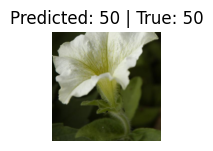

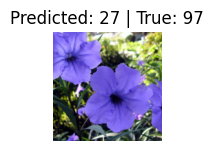

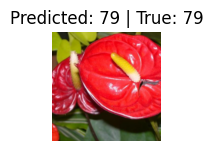

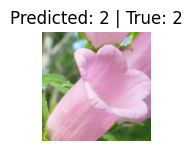

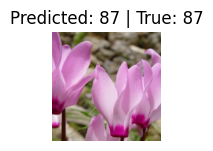

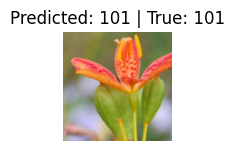

In [11]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                # Changed classes to labels so it corresponds to the labels from dataloader['val']
                ax.set_title(f'Predicted: {preds[j]} | True: {labels[j]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

visualize_model(model)

In [12]:
def plot_graph(no_epoch, train, val, title):
    plt.figure()
    plt.plot(range(no_epoch), train, label='train')
    plt.plot(range(no_epoch), val, label='val')
    if "Accuracy" in title:
        plt.ylabel("Accuracy")
    elif "Loss" in title:
        plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.show()

Plotting the epoch vs accuracy and epoch vs loss here. 

The model's best validation accuracy is at 83.24%.

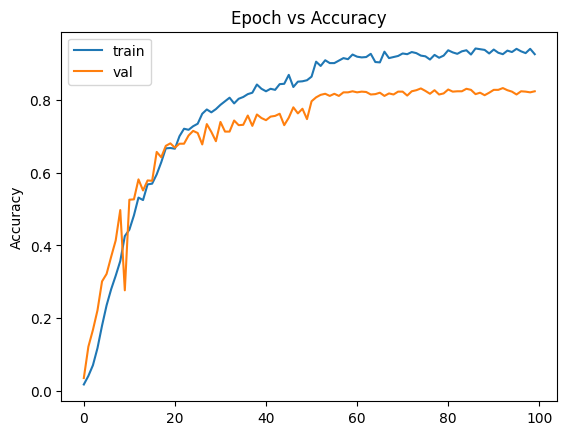

In [13]:
for i in range(len(train_acc)):
    train_acc[i] = train_acc[i].cpu()
    val_acc[i] = val_acc[i].cpu()

plot_graph(no_epochs, train_acc, val_acc, "Epoch vs Accuracy")

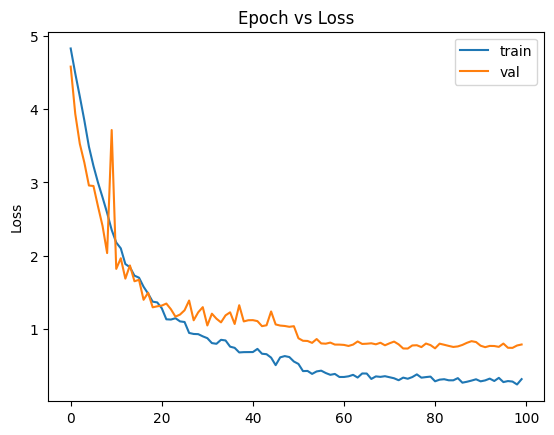

In [14]:
plot_graph(no_epochs, train_loss, val_loss, "Epoch vs Loss")

In [15]:
def test(model):
    was_training = model.training
    model.eval()
    # fig = plt.figure()
    size = len(dataloaders['test'].dataset)
    no_batches = len(dataloaders['test'])
    test_loss, correct = 0, 0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            test_loss += criterion(outputs, labels).item() * inputs.size(0)
            correct += torch.sum(preds == labels.data)
            if i % 50 == 0:
                print(f'Predicted: {preds[0]} | True: {labels[0]}')
            # for j in range(inputs.size()[0]):
            #     images_so_far += 1
                # ax = plt.subplot(num_images//2, 2, images_so_far)
                # ax.axis('off')
                # Changed classes to labels so it corresponds to the labels from dataloader['val']
                # ax.set_title(f'Predicted: {preds[j]} | True: {labels[j]}')
                # imshow(inputs.cpu().data[j])

                # if images_so_far == num_images:
                    # model.train(mode=was_training)
                    # return
    test_loss /= size
    correct = correct.double() / size
    model.train(mode=was_training)
    return test_loss, correct

In [16]:
test_loss, test_acc = test(model)

Predicted: 72 | True: 72
Predicted: 71 | True: 71
Predicted: 55 | True: 55
Predicted: 59 | True: 59
Predicted: 45 | True: 45
Predicted: 71 | True: 50
Predicted: 10 | True: 10
Predicted: 70 | True: 70
Predicted: 30 | True: 93
Predicted: 73 | True: 73
Predicted: 62 | True: 62
Predicted: 12 | True: 12
Predicted: 76 | True: 76
Predicted: 45 | True: 45
Predicted: 59 | True: 59
Predicted: 71 | True: 81
Predicted: 80 | True: 80
Predicted: 101 | True: 101
Predicted: 85 | True: 85
Predicted: 76 | True: 76
Predicted: 50 | True: 50
Predicted: 15 | True: 15
Predicted: 60 | True: 60
Predicted: 35 | True: 35
Predicted: 43 | True: 43
Predicted: 100 | True: 85
Predicted: 50 | True: 50
Predicted: 94 | True: 94
Predicted: 97 | True: 97
Predicted: 80 | True: 80
Predicted: 68 | True: 68
LAST LAYER: 1


Testing the model.

The model has a test accuracy of 78.44%.

It has a significant increase in accuracy in comparison with the model with deformed convolution AFTER the conv1 layer.

However, it still is not performing as well as the original ResNet18 model (Unfrozen).

In [17]:
print(f'Test Loss:\t{test_loss:.4f}\tTest Acc:\t{test_acc:.4f}')

Test Loss:	0.9736	Test Acc:	0.7844


In [18]:
print(f"{model}")

deformed_CNN(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=Tr